In [1]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

class StatsQuantizer(nn.Module):
    def __init__(self, num_bits, clip_learnable):
        super(StatsQuantizer, self).__init__()
        self.num_bits = num_bits
        init_act_clip_val = 2.0

        self.clip_val = nn.Parameter(torch.Tensor([init_act_clip_val]), requires_grad=False)

        self.s = None

    
    def forward(self, weight):

        real_weights = weight

        if len(weight.shape) == 2:
            scaling_factor = 2 * torch.mean(abs(real_weights),dim=1,keepdim=True) # dim, 1
        elif len(weight.shape) == 3:
            scaling_factor = 2 * torch.mean(torch.mean(abs(real_weights),dim=-1,keepdim=True),dim=0,keepdim=True) # 1, dim, 1

        scaling_factor = scaling_factor.detach()
        self.s = scaling_factor.squeeze().cpu()
        scaled_weights = real_weights/scaling_factor
        cliped_weights = torch.clamp(scaled_weights, min=(-self.clip_val/2), max=(self.clip_val/2)-1e-6)
        n = float(2 ** (self.num_bits - 1))
        quan_weights_no_grad = scaling_factor * ((torch.round((cliped_weights) * n - 0.5 ) + 0.5) / n)
        quan_weights = quan_weights_no_grad.detach() - real_weights.detach() + real_weights

        return quan_weights
    

class AdaRoundQuantizer(nn.Module):
    """
    Adaptive Rounding Quantizer, used to optimize the rounding policy
    by reconstructing the intermediate output.
    Based on
     Up or Down? Adaptive Rounding for Post-Training Quantization: https://arxiv.org/abs/2004.10568

    :param uaq: UniformAffineQuantizer, used to initialize quantization parameters in this quantizer
    :param round_mode: controls the forward pass in this quantizer
    :param weight_tensor: initialize alpha
    """

    def __init__(self, wbits=2,sym= False, weight_tensor: torch.Tensor=None, round_mode='learned_hard_sigmoid'):
        super(AdaRoundQuantizer, self).__init__()
        # copying all attributes from UniformAffineQuantizer
        self.sym = sym
        self.delta = nn.Parameter(torch.Tensor([1]), requires_grad=True)
        self.zero_point = nn.Parameter(torch.Tensor([0]), requires_grad=True)
        self.n_levels = 2 ** wbits

        self.round_mode = round_mode
        self.alpha = None
        self.soft_targets = True

        # params for sigmoid function
        self.gamma, self.zeta = -0.1, 1.1
        self.beta = 2/3
        self.init_alpha(x=weight_tensor.clone())
        self.scale = self.delta

    def forward(self, x,soft_targets=True):
        if self.round_mode == 'nearest':
            x_int = torch.round(x / self.delta)
        # elif self.round_mode == 'nearest_ste':
        #     x_int = round_ste(x / self.delta)
        elif self.round_mode == 'stochastic':
            x_floor = torch.floor(x / self.delta)
            rest = (x / self.delta) - x_floor  # rest of rounding
            x_int = x_floor + torch.bernoulli(rest)
            print('Draw stochastic sample')
        elif self.round_mode == 'learned_hard_sigmoid':
            x_floor = torch.floor(x / self.delta)
            if soft_targets:
                x_int = x_floor + self.get_soft_targets()
            else:
                x_int = x_floor + (self.alpha >= 0).float()
        else:
            raise ValueError('Wrong rounding mode')

        x_quant = torch.clamp(x_int + self.zero_point, 0, self.n_levels - 1)
        x_float_q = (x_quant - self.zero_point) * self.delta

        return x_float_q

    def get_soft_targets(self):
        return torch.clamp(torch.sigmoid(self.alpha) * (self.zeta - self.gamma) + self.gamma, 0, 1)

    def init_alpha(self, x: torch.Tensor):
        x_floor = torch.floor(x / self.delta)
        if self.round_mode == 'learned_hard_sigmoid':
            print('Init alpha to be FP32')
            rest = (x / self.delta) - x_floor  # rest of rounding [0, 1)
            alpha = -torch.log((self.zeta - self.gamma) / (rest - self.gamma) - 1)  # => sigmoid(alpha) = rest
            self.alpha = nn.Parameter(alpha)
        else:
            # raise NotImplementedError
            pass

class QLinear(nn.Linear):

    def __init__(self, *kargs, m: torch.nn.Linear, weight_bits=2, input_bits=8, aq_learnable=True, wq_learnable = True,
                 symmetric=True, weight_channelwise=True, input_channelwise=True, weight_quant_method="statsq", input_quant_method="lsq",
                 pretrained_initialized = False,
                 **kwargs):
        super(QLinear, self).__init__(m.in_features, m.out_features,bias=True)
        self.weight_bits = weight_bits
        self.input_bits = input_bits
        self.aq_learnable = aq_learnable
        self.wq_learnable = wq_learnable
        self.symmetric = symmetric
        self.weight_channelwise = weight_channelwise # not gonna used atm
        self.input_channelwise = input_channelwise
        self.weight_quant_method = weight_quant_method
        self.input_quant_method = input_quant_method
        self.pretrained_initialized = pretrained_initialized
        self.weight = torch.nn.Parameter(m.weight.detach())
        if m.bias is not None:
            self.bias = torch.nn.Parameter(m.bias.detach())
        # self.statsq_fn = StatsQuantizer(num_bits=self.weight_bits, clip_learnable=wq_learnable).to(m.weight.device)
        self.weight_quantizer = AdaRoundQuantizer(weight_tensor=m.weight).to(m.weight.device)

    def get_inferred_params(self):
        int_weight = self.weight_quantizer(self.weight,True)
        scale = self.weight_quantizer.scale
        return int_weight, scale.unsqueeze(0), torch.tensor([0.0])
    def set_quant_state(self,state):
        pass
    def forward(self, input):

        # quantize weight
        if self.weight_quant_method == 'statsq':
            weight = self.weight_quantizer(self.weight)
        else:
            raise ValueError("Unknown quant_method")    
        # quantize input
        out = nn.functional.linear(input, weight)
        if not self.bias is None:
            out += self.bias.view(1, -1).expand_as(out)

        return out

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from EfficientQAT.quantize.int_linear_fake import QuantLinear
# Parameters
input_dim = 64
output_dim = 1
num_samples = 320
device = torch.device("cuda:5")

torch.manual_seed(42)

# Generating synthetic data
X = torch.randn(num_samples, input_dim)*7  # Input features
# add outlier
add_dim = torch.randint(0, input_dim, (1,))
X[:,add_dim]+= torch.randn(1)*10


true_weights = torch.randn(input_dim, output_dim)  # True weights
# true_weights = torch.tensor([[4] ,[1.8],[0.03]])

# true_bias = torch.randn(output_dim)  # True bias
y = X @ true_weights + torch.randn_like(X @ true_weights) * 0.0005  # Adding noise


# Creating dataset and dataloader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Defining a linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.in_features = input_dim
        self.out_features = output_dim
        self.group_size = input_dim
        self.linear = QuantLinear(self.linear, wbits=2, group_size=self.group_size,args={
            # "gradual_quant":True,
            "iterative_freezing":True,
            "freeze_threshold":0.0,
            "round_method": "highpass",
        })
        # self.linear = QLinear(m=self.linear)
        with torch.no_grad():
            self.linear.weight_quantizer.scale+=2
        self.linear.bias = None
        self.linear.set_quant_state(True)
        # print(self.linear.weight_quantizer.scale)
        # print(self.linear.weight.amin([-1], keepdim=True))
        self.bits =2
        self.logs = {
            "steps": [],
        }
        # 根据 in_features 动态生成 position 键
        for i in range(self.in_features):
            self.logs[f"weight_position_{i}"] = (0, i)  # 假设每个权重位置的元组为 (0, i)
            self.logs[f"quant_weight_{i}"] = []
            self.logs[f"quant_zero_point_{i}"] = []
            self.logs[f"quant_scale_{i}"] = []

        self.step = 0

    def forward(self, x):
        return self.linear(x)
    
    def examine_weights(self):
        # 遍历所有生成的 weight_position 键，并监控权重
        for i in range(self.in_features):
            weight_position = self.logs[f"weight_position_{i}"]  # 获取该位置
            prod = weight_position[0] * self.in_features + weight_position[1]
            g_idx = (prod // self.group_size, prod % self.group_size)

            # 获取量化参数
            int_weight, scale, zero_point = self.linear.get_inferred_params()

            # 更新日志
            self.logs[f"quant_weight_{i}"].append(int_weight.reshape(-1, self.group_size)[g_idx].clone().detach().cpu().item())
            self.logs[f"quant_zero_point_{i}"].append(zero_point[g_idx[0]].clone().detach().cpu().item())
            self.logs[f"quant_scale_{i}"].append(scale[g_idx[0]].clone().detach().cpu().item())

        # 更新步数
        self.logs["steps"].append(self.step)
        self.step += 1

# Initialize the model
model = LinearRegressionModel(input_dim, output_dim)
# Move the model to device
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)


loss_list = []

# Train the model
for epoch in range(100):
    running_loss = 0.0
    # if epoch %4:
    # if epoch == 10:
        
    for i, data in enumerate(dataloader, 0):
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = param_group['lr'] / (model.step+1)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # loss+= model.linear.get_dampen_loss()*0.01

        loss.backward()

        # norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)
        with torch.no_grad():
            model.examine_weights()
            # print(f"weight grad {model.linear.weight.grad} scale grad {model.linear.weight_quantizer.scale.grad} zero_point grad {model.linear.weight_quantizer.zero_point.grad}")
        with torch.no_grad():
            grad = model.linear.weight.grad

            grad_flattened = grad.view(-1)  # 将梯度展平

            _, select_indices = torch.topk(torch.abs(grad_flattened), k=4)  # 获取绝对值最大的前8个索引

             # 随机选择4个位置的索引
            # total_elements = grad_flattened.numel()  # 梯度中的总元素数
            # select_indices = torch.randperm(total_elements)[:4]  # 随机选择4个索引

            # 创建一个零张量，设置前8个最大值的位置为原始梯度值
            # mask = torch.zeros_like(grad_flattened)
            # mask[select_indices] = 1.0  # 标记随机选中的位置
            

            # 选择大于阈值的梯度
            threshold = grad_flattened.abs().mean()  # 简单使用平均值作为阈值
            mask = (grad_flattened.abs() >= threshold).float()  # 大于阈值的位置为1，其他为0

            # 将 mask 还原为原始形状，并应用于梯度
            mask = mask.view_as(grad)  # 还原为原始形状
            grad = grad * mask  # 保留前8个最大值，其他位置设置为0

            # 将修改后的梯度重新赋值回模型
            model.linear.weight.grad = grad

        optimizer.step()
        running_loss += loss.item()
        loss_list.append(loss.item())
    scheduler.step()
    print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader)}")

# Test the model
with torch.no_grad():
    inputs, labels = next(iter(dataloader))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    # print(f"Test loss: {criterion(outputs, labels)}")

round_method: highpass
Epoch 1 loss: 2819.34296875
Epoch 2 loss: 775.524072265625
Epoch 3 loss: 590.935205078125
Epoch 4 loss: 448.32274475097654
Epoch 5 loss: 507.58306884765625
Epoch 6 loss: 557.7033111572266
Epoch 7 loss: 540.6383056640625
Epoch 8 loss: 542.625390625
Epoch 9 loss: 689.7519012451172
Epoch 10 loss: 545.9890289306641
Epoch 11 loss: 637.4066589355468
Epoch 12 loss: 553.3058349609375
Epoch 13 loss: 595.0483581542969
Epoch 14 loss: 500.9123046875
Epoch 15 loss: 584.0697601318359
Epoch 16 loss: 530.7977661132812
Epoch 17 loss: 608.2370483398438
Epoch 18 loss: 489.3213165283203
Epoch 19 loss: 592.8837738037109
Epoch 20 loss: 608.1857971191406
Epoch 21 loss: 464.86953125
Epoch 22 loss: 540.7240478515625
Epoch 23 loss: 624.1330322265625
Epoch 24 loss: 558.4048706054688
Epoch 25 loss: 559.7522735595703
Epoch 26 loss: 569.4807159423829
Epoch 27 loss: 601.2422241210937
Epoch 28 loss: 631.7252685546875
Epoch 29 loss: 621.9675018310547
Epoch 30 loss: 519.5525024414062
Epoch 31 los

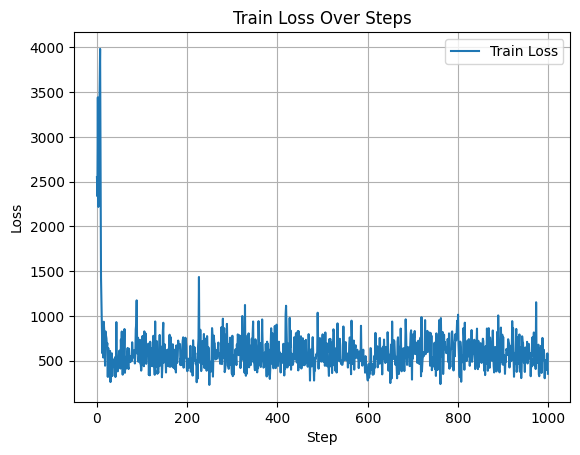

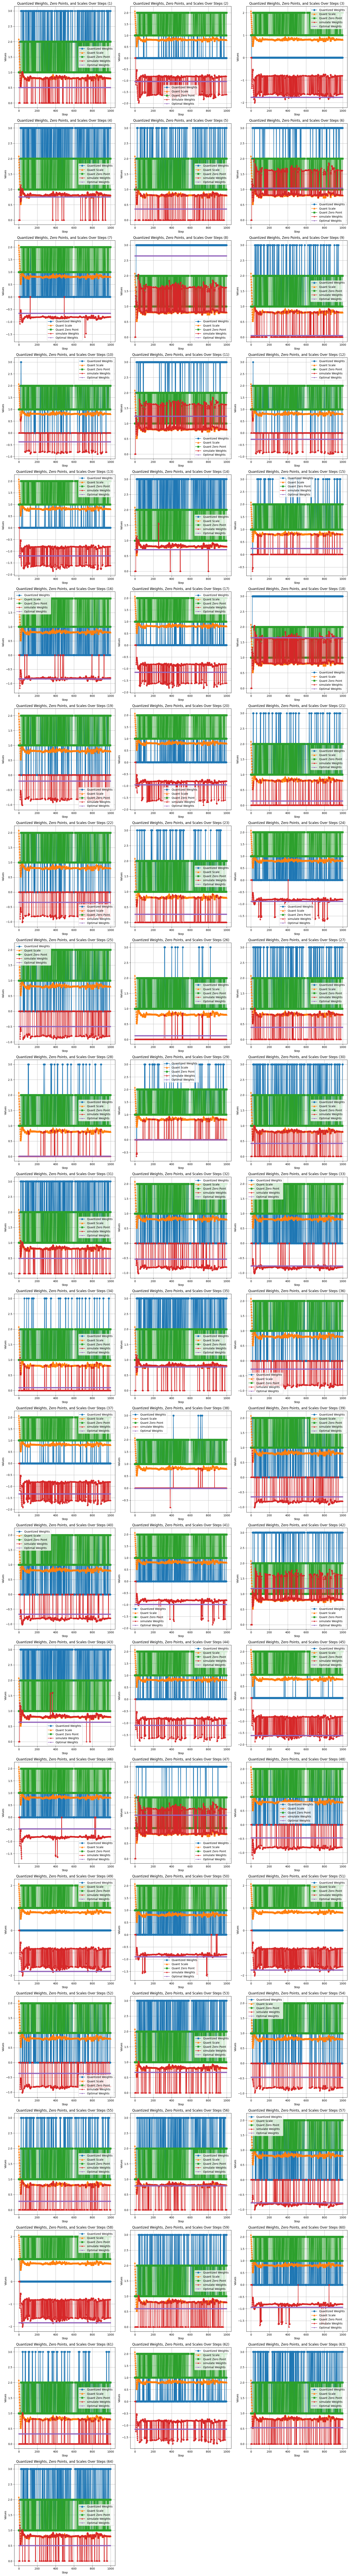

In [3]:
import matplotlib.pyplot as plt
import numpy as np
steps = model.logs["steps"]  # Example step range

# draw loss 

plt.plot(steps, loss_list, label="Train Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train Loss Over Steps")
plt.legend()
plt.grid(True)
plt.show()

# 设置每行最多 3 个子图
max_columns = 3
num_subplots = model.in_features  # 子图数量 = 输入特征数量

# 计算需要多少行
num_rows = (num_subplots + max_columns - 1) // max_columns  # 向上取整

# 设置图形窗口，包含合适数量的子图
fig, axes = plt.subplots(num_rows, max_columns, figsize=(max_columns * 6, num_rows * 6))

# 如果只有一个子图时，axes会变成单一的对象，需要确保它始终是一个列表或二维数组
if num_rows == 1:
    axes = [axes]
elif num_subplots == 1:
    axes = [[ax] for ax in axes]

# 遍历所有输入维度并绘制相应的图表
for i in range(num_subplots):
    row = i // max_columns  # 当前行
    col = i % max_columns   # 当前列
    
    # 获取该位置的子图对象
    ax = axes[row][col]
    
    # 获取量化权重、零点、尺度等数据
    quant_weights = model.logs[f"quant_weight_{i}"]
    quant_zero_points = model.logs[f"quant_zero_point_{i}"]
    quant_scales = model.logs[f"quant_scale_{i}"]

    step = np.array(steps)
    quant_weight = np.array(quant_weights)
    quant_zero_point = np.array(quant_zero_points)
    quant_scale = np.array(quant_scales)
    
    # 假设真实权重从模型中获取，可能需要根据你的实现修改这部分
    real_weight = (quant_weight - quant_zero_point) * quant_scale
    optimal = true_weights[i, 0].item()  # 假设真实权重是true_weights的第i行
    optimal = np.array([optimal] * len(step))

    # 绘制当前子图
    ax.plot(steps, quant_weights, label="Quantized Weights", marker='o')
    ax.plot(steps, quant_scales, label="Quant Scale", marker='^')
    ax.plot(steps, quant_zero_points, label="Quant Zero Point", marker='s')
    ax.plot(steps, real_weight, label="simulate Weights", marker='*')
    ax.plot(steps, optimal, label="Optimal Weights", marker='.')
    ax.set_xlabel("Step")
    ax.set_ylabel("Values")
    ax.set_title(f"Quantized Weights, Zero Points, and Scales Over Steps ({i+1})")
    ax.legend()
    ax.grid(True)

# 隐藏多余的子图（如果有的话）
for i in range(num_subplots, num_rows * max_columns):
    row = i // max_columns
    col = i % max_columns
    axes[row][col].axis('off')  # 隐藏不需要的子图

# 自动调整布局以防止重叠
plt.tight_layout()

# 显示图形
plt.show()